In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import os


data = []
labels = []
IMG_SIZE = 224
for i in os.listdir('/kaggle/input/nn23-sports-image-classification/Train'):
    img = cv.imread('/kaggle/input/nn23-sports-image-classification/Train/'+i)
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    img = cv.resize(img,(IMG_SIZE,IMG_SIZE))
    data.append(img)
    labels.append(i.split('_')[0])

print(len(data))
print(labels[0])

1681
Yoga


# Preprocessing

In [22]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
train_labels = le.fit_transform(labels)
train_labels = np_utils.to_categorical(train_labels, len(np.unique(train_labels)))

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(np.array(data), np.array(train_labels), test_size=0.20, random_state=42)

# normalize the data
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0

print(len(trainX))
print(len(testX))

1344
337


# Data Augmentation

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
train_gen = train_datagen.flow(trainX,trainY,batch_size=64)

# Model

In [102]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras import *
    
def Depthwise_Separable_Conv(strides_depthwise, padding_depthwise, filters_pointwise, layer):
    layer = tf.keras.layers.DepthwiseConv2D(kernel_size= (3,3), strides= strides_depthwise, padding= padding_depthwise, use_bias = False)(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.ReLU()(layer)
    
    layer = tf.keras.layers.Conv2D(filters= int(filters_pointwise), padding= 'same', kernel_size= (1,1), strides= (1,1), use_bias = False)(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.ReLU()(layer)
    return layer 
    
    

In [120]:

inputs = tf.keras.layers.Input(shape= (224,224,3))
layer = Conv2D(filters= 32, kernel_size=(3,3), strides= (2,2), padding= 'same', use_bias = False)(inputs)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)
# Depth_Separable_Conv 1
layer =Depthwise_Separable_Conv(strides_depthwise= (1,1), padding_depthwise= 'same',filters_pointwise= 64, layer = layer)
# Depth_Separable_Conv 2
layer = Depthwise_Separable_Conv(strides_depthwise= (2,2), padding_depthwise= 'same', filters_pointwise= 128, layer = layer)
# Depth_Separable_Conv 3
layer =Depthwise_Separable_Conv(strides_depthwise= (1,1), padding_depthwise= 'same', filters_pointwise= 128, layer = layer)
# Depth_Separable_Conv 4
layer =Depthwise_Separable_Conv(strides_depthwise= (2,2), padding_depthwise= 'same', filters_pointwise= 256, layer = layer)
# Depth_Separable_Conv 5
layer =Depthwise_Separable_Conv(strides_depthwise= (1,1), padding_depthwise= 'same', filters_pointwise= 256, layer = layer)
# Depth_Separable_Conv 6
layer =Depthwise_Separable_Conv(strides_depthwise= (2,2), padding_depthwise= 'same', filters_pointwise= 512, layer = layer)
# Depth_Separable_Conv 7 - > 11
layer =Depthwise_Separable_Conv(strides_depthwise= (1,1), padding_depthwise= 'same', filters_pointwise= 512, layer = layer)
layer =Depthwise_Separable_Conv(strides_depthwise= (1,1), padding_depthwise= 'same', filters_pointwise= 512, layer = layer)
layer =Depthwise_Separable_Conv(strides_depthwise= (1,1), padding_depthwise= 'same', filters_pointwise= 512, layer = layer)
layer =Depthwise_Separable_Conv(strides_depthwise= (1,1), padding_depthwise= 'same', filters_pointwise= 512, layer = layer)
layer =Depthwise_Separable_Conv(strides_depthwise= (1,1), padding_depthwise= 'same', filters_pointwise= 512, layer = layer)
# Depth_Separable_Conv 12
layer =Depthwise_Separable_Conv(strides_depthwise= (2,2), padding_depthwise= 'same', filters_pointwise= 1024, layer = layer)

# Depth_Separable_Conv 13
layer =Depthwise_Separable_Conv(strides_depthwise= (2,2), padding_depthwise= 'same', filters_pointwise= 1024, layer = layer)

model = Model(inputs, layer)

In [121]:
model.load_weights("/kaggle/input/mobilenet-1-0-224-tf-no-toph5/mobilenet_1_0_224_tf_no_top.h5")

for layer in model.layers :
    layer.trainable = False 
    
# FC
cont_layers = model.output
cont_layers = Flatten()(cont_layers)
cont_layers = Dense(256, activation= 'relu')(cont_layers)
cont_layers = tf.keras.layers.BatchNormalization()(cont_layers)
cont_layers = Dropout(0.001)(cont_layers)
cont_layers = Dense(6, activation= 'softmax')(cont_layers)
model = Model(model.input, cont_layers)
model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_226 (Conv2D)          (None, 112, 112, 32)      864       
_________________________________________________________________
batch_normalization_416 (Bat (None, 112, 112, 32)      128       
_________________________________________________________________
re_lu_414 (ReLU)             (None, 112, 112, 32)      0         
_________________________________________________________________
depthwise_conv2d_208 (Depthw (None, 112, 112, 32)      288       
_________________________________________________________________
batch_normalization_417 (Bat (None, 112, 112, 32)      128       
_________________________________________________________________
re_lu_415 (ReLU)             (None, 112, 112, 32)      0  

In [122]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
checkpoint = ModelCheckpoint('model.h5',monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False,mode='auto',period=1)
early = EarlyStopping(monitor='val_loss',min_delta=0,patience=50,verbose=1,mode='auto')


hist = model.fit(train_gen,epochs=400,validation_data=(testX,testY),callbacks=[checkpoint,early])

Epoch 1/400
21/21 [==============================] - 19s 784ms/step - loss: 0.7179 - accuracy: 0.7731 - val_loss: 1.2384 - val_accuracy: 0.8398

Epoch 00001: val_loss improved from inf to 1.23836, saving model to model.h5
Epoch 2/400
21/21 [==============================] - 14s 678ms/step - loss: 0.2844 - accuracy: 0.9062 - val_loss: 0.5097 - val_accuracy: 0.8961

Epoch 00002: val_loss improved from 1.23836 to 0.50974, saving model to model.h5
Epoch 3/400
21/21 [==============================] - 15s 712ms/step - loss: 0.2127 - accuracy: 0.9301 - val_loss: 0.3651 - val_accuracy: 0.9199

Epoch 00003: val_loss improved from 0.50974 to 0.36510, saving model to model.h5
Epoch 4/400
21/21 [==============================] - 15s 695ms/step - loss: 0.1498 - accuracy: 0.9487 - val_loss: 0.2248 - val_accuracy: 0.9288

Epoch 00004: val_loss improved from 0.36510 to 0.22479, saving model to model.h5
Epoch 5/400
21/21 [==============================] - 15s 723ms/step - loss: 0.1449 - accuracy: 0.952

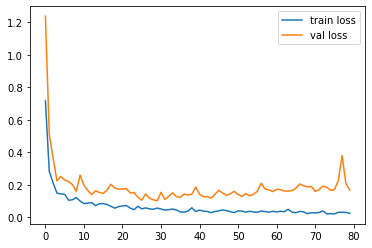

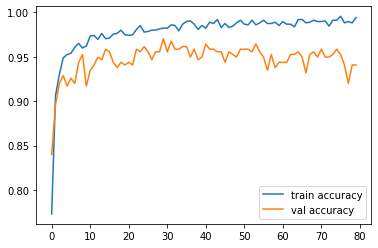

In [123]:
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(hist.history['accuracy'], label='train accuracy')
plt.plot(hist.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

# Evaluation

In [126]:
from tensorflow.keras.models import load_model
best_model = load_model('/kaggle/working/model.h5')

In [135]:
best_model.evaluate(testX,testY)

11/11 [==============================] - 0s 37ms/step - loss: 0.1031 - accuracy: 0.9703


[0.10309400409460068, 0.9703264236450195]

# Reading Test Data

In [128]:
test_data = []
for i in os.listdir('/kaggle/input/nn23-sports-image-classification/Test'):
    img = cv.imread('/kaggle/input/nn23-sports-image-classification/Test/'+i)
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    img = cv.resize(img,(IMG_SIZE,IMG_SIZE))
    test_data.append(np.array(img))
test_data = np.array(test_data)
test_data = test_data/255.0

print(len(test_data))

688


# Predictions

In [136]:
pred = best_model.predict(test_data)
pred = np.argmax(pred,axis=1)
print(pred)
df = pd.DataFrame({'image_name':os.listdir('/kaggle/input/nn23-sports-image-classification/Test'),'Label':pred})
df.to_csv('submissiontrial13.csv',index=False)
df

[2 5 0 1 1 0 0 5 4 4 5 4 3 3 5 2 3 4 4 3 3 2 4 1 1 5 4 0 0 4 5 2 2 5 3 5 4
 1 2 4 2 5 5 1 0 4 4 3 0 5 3 1 5 4 0 1 1 3 5 4 0 2 4 4 2 4 0 3 2 4 1 1 3 4
 2 1 4 2 5 4 1 2 5 5 0 0 0 3 3 5 0 2 2 2 1 5 5 0 3 4 0 3 1 3 0 2 2 3 3 0 2
 3 4 3 1 5 1 0 2 4 2 5 1 1 3 2 1 5 3 0 0 1 0 5 5 5 1 3 2 4 4 2 3 3 3 2 3 3
 5 4 2 0 2 4 5 2 2 5 1 2 5 0 5 1 5 4 5 1 3 1 3 2 2 1 3 2 5 2 2 2 4 3 1 5 5
 0 1 0 4 2 2 3 5 1 0 5 1 4 1 3 4 0 1 4 1 2 4 2 3 4 1 4 1 5 2 4 5 5 1 3 1 1
 0 5 4 1 2 3 0 0 0 0 2 2 2 4 5 5 4 1 2 2 1 1 5 4 5 3 5 0 1 5 4 1 4 4 2 3 1
 3 3 5 1 1 0 5 5 5 4 5 1 0 5 5 1 5 3 5 4 5 4 0 3 4 4 5 4 0 1 5 3 3 1 5 1 1
 2 1 3 0 1 1 3 1 5 2 1 4 1 1 5 4 1 5 3 4 1 4 1 3 2 0 1 5 4 1 0 3 0 1 3 1 0
 4 3 0 0 5 5 1 2 1 1 4 3 5 3 1 1 4 5 4 4 3 1 5 2 4 1 3 4 5 1 3 3 5 2 2 2 1
 0 1 5 5 5 3 1 4 5 4 0 3 0 3 4 2 1 3 5 5 1 3 2 1 0 5 3 4 2 2 0 0 4 1 3 5 1
 4 1 3 1 0 4 5 5 5 3 1 1 1 1 2 2 3 4 0 3 4 1 5 5 4 3 4 5 0 3 0 4 5 4 1 5 2
 0 1 3 2 1 0 0 2 1 1 1 0 1 3 3 3 1 1 3 3 0 4 5 3 3 5 5 5 2 2 2 3 2 0 5 5 1
 0 0 0 0 0 5 0 1 5 3 5 5 

,image_name,Label
0,623.jpg,2
1,208.jpg,5
2,473.jpg,0
3,333.jpg,1
4,537.jpg,1
...,...,...
683,364.jpg,3
684,90.jpg,3
685,599.jpg,4
686,25.jpg,4


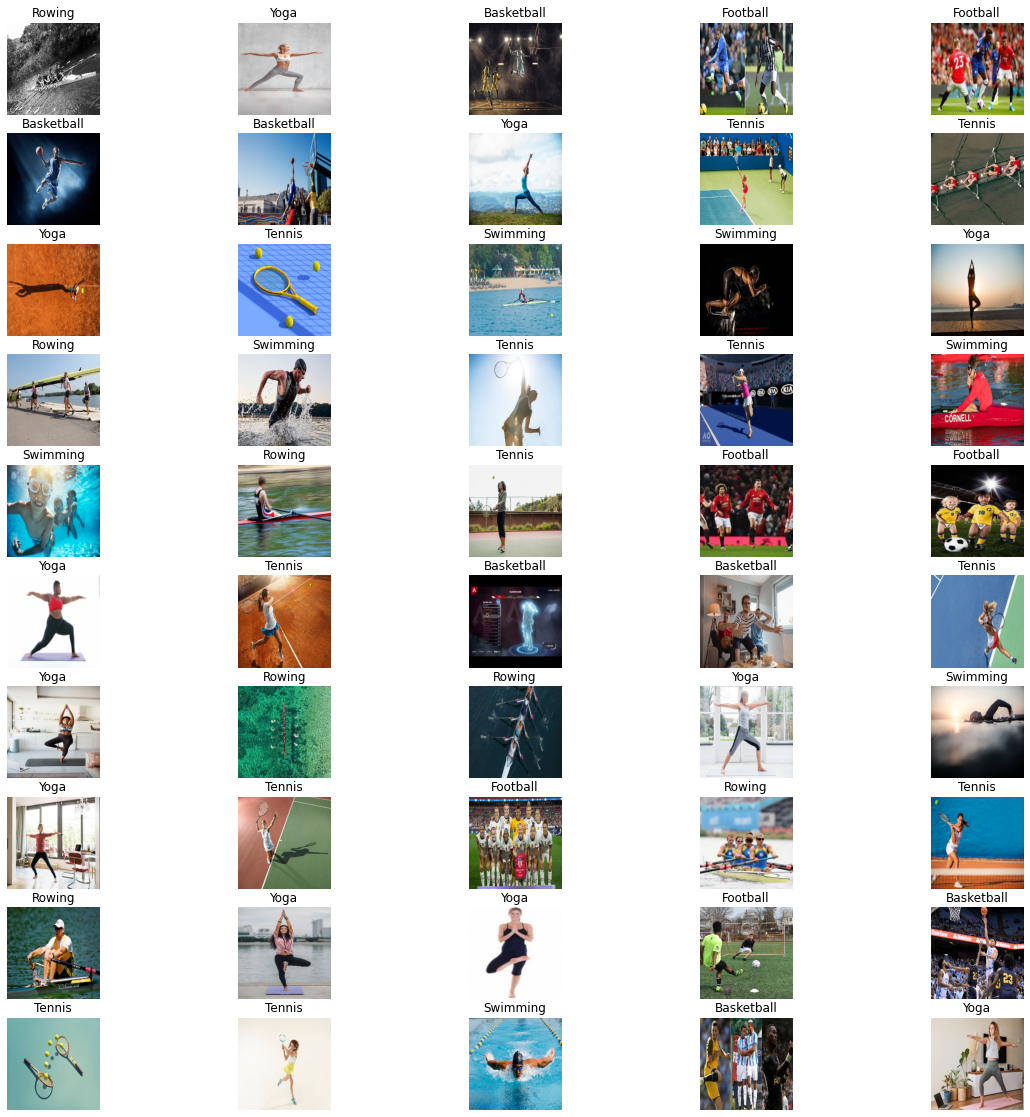

In [137]:
pred = le.inverse_transform(pred)
plt.figure(figsize=(20,20))
for i in range(50):
    plt.subplot(10,5,i+1)
    plt.imshow(test_data[i])
    plt.title(pred[i])
    plt.axis('off')
plt.show()

In [138]:
model.save('modeltrial13.h5')
import pickle
f = open('label_encoder13.pkl', "wb")
f.write(pickle.dumps(le))
f.close()

from IPython.display import FileLink
FileLink(r'modeltrial13.h5')


/kaggle/working/modeltrial13.h5